In [1]:
import glob
import cv2
import os

import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import tensorflow.keras.optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16, EfficientNetB0
print(tf.__version__)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import manifold

import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
from matplotlib import offsetbox
import matplotlib.colors as colors
import matplotlib.cm as cmx

2022-10-19 17:15:25.847998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


# Load Images and Labels
 load product images and corresponding category labels, compute basic statistics, and visualize image examples.

In [2]:
base_path = '/Users/jiaohongmei/info7374/assign2/clothing-dataset-master'
df = pd.read_csv(base_path + '/images.csv')
df = df[df['label'].isin(['Shoes', 'Dress', 'Longsleeve', 'T-Shirt', 'Hat'])]

data, labels = [], []
for index, row in df.iterrows():
    image_path = f'{base_path}/images/{row["image"]}.jpg'
    label = row['label']
    try:
        #set images's resolution to 224 to fit EfficientNet0 model
        image = tf.keras.preprocessing.image.load_img(image_path, color_mode='rgb', target_size= (224, 224))
        image = np.array(image)
        data.append(image)
        labels.append(label)
    except Exception:
        print(f'Failed to load {image_path}')
        
print(f'Loaded {len(data)} images') 

label_set = list(set(df['label']))
print(f'Image classes {label_set}')
print(df[['label', 'image']].groupby(['label']).agg(['count']))


Loaded 2669 images
Image classes ['Longsleeve', 'Dress', 'Shoes', 'Hat', 'T-Shirt']
           image
           count
label           
Dress        357
Hat          171
Longsleeve   699
Shoes        431
T-Shirt     1011


In [3]:
#
# Data pre-processing
#
x = np.array(data)
y = np.array(labels)

# EfficientNet models expect their inputs to be float tensors 
# of pixels with values in the [0-255] range.
x = x.astype('float32') 

mlb = MultiLabelBinarizer()
mlb.fit([label_set])
y = mlb.transform(np.atleast_2d(y).T)
print(f'Label mapper classes {mlb.classes_}')


#
# Data split
#
# x - n_samples X height X width X channels
# y - n_samples X onehot_labels
train_test_ratio = 0.75
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_test_ratio)
print(f'x_train: {x_train.shape}, x_test: {x_test.shape}')
print(f'y_train: {y_train.shape}, y_test: {y_test.shape}')

Label mapper classes ['Dress' 'Hat' 'Longsleeve' 'Shoes' 'T-Shirt']
x_train: (2001, 224, 224, 3), x_test: (668, 224, 224, 3)
y_train: (2001, 5), y_test: (668, 5)


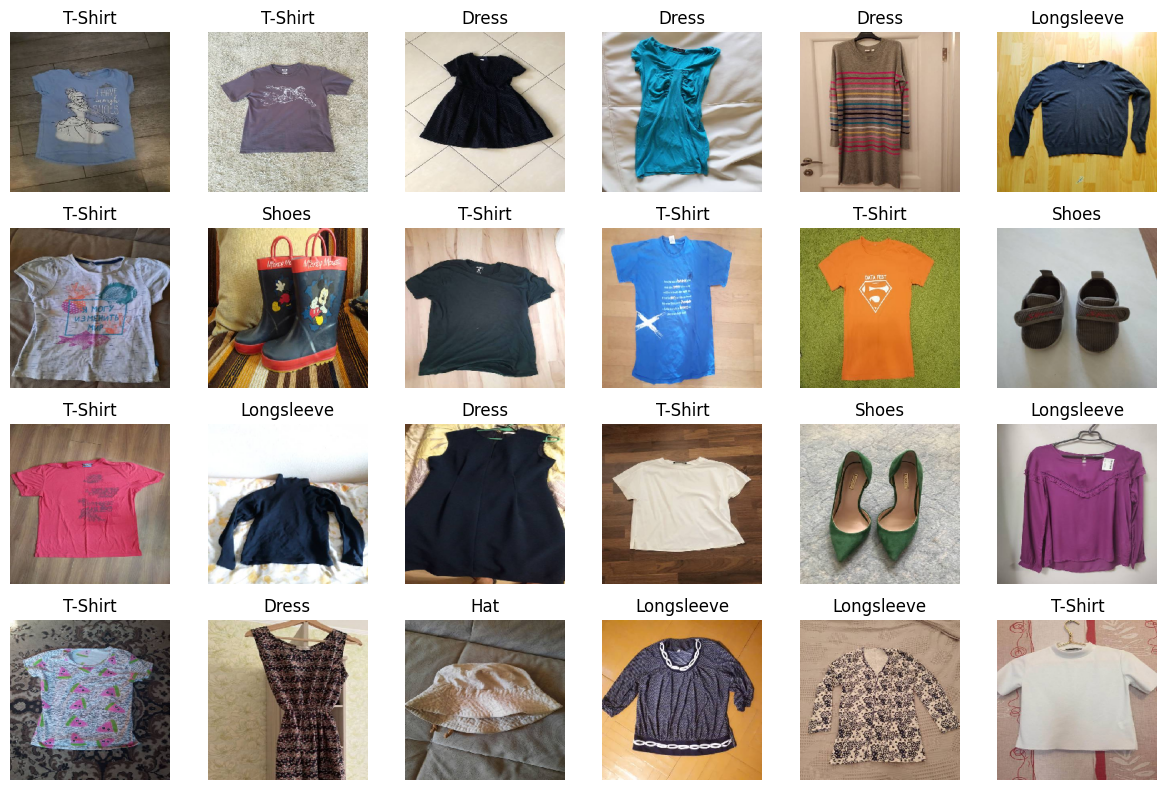

In [4]:
#
# Visualize a data sample 
#
def decode_labels(y, mlb):
    labels = np.array(mlb.inverse_transform(np.atleast_2d(y)))[:, 0]
    return labels

n_col, n_row = 6, 4
offset = 200
f, ax = plt.subplots(n_row, n_col, figsize=(12, 8))
for i in range(n_row):
    for j in range(n_col):
        idx = offset + n_col*i + j
        ax[i, j].imshow(x_train[idx]/255)
        ax[i, j].set_axis_off()
        ax[i, j].set_title(decode_labels(y_train[idx], mlb)[0])
plt.tight_layout()

# Fit a Classification Model

We use a pre-trained EfficientNetB0 model and fine-tune it using the dataset prepared above to predict domain-specific labels.

In [5]:
#
# Fine-tune a pretrained EfficientNet model   
#
model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in model.layers:
    layer.trainable = False
    
mapper = model.output
mapper = Flatten()(mapper) 
mapper = Dense(32, activation='relu', name='embeddigns')(mapper)
mapper = Dense(y_train.shape[1], activation='softmax')(mapper)
transfer_model = Model(inputs=model.input, outputs=mapper)

learning_rate= 0.001
transfer_model.compile(loss="categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics = ["accuracy"])
history = transfer_model.fit(x_train, y_train, batch_size = 4, epochs=4, validation_data=(x_test, y_test))

2022-10-19 17:48:00.047009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


16705208/16705208 [==============================] - 33s 2us/step
Epoch 1/4
501/501 [==============================] - 245s 468ms/step - loss: 0.9142 - accuracy: 0.8636 - val_loss: 0.4568 - val_accuracy: 0.9087
Epoch 2/4
501/501 [==============================] - 214s 427ms/step - loss: 0.2444 - accuracy: 0.9455 - val_loss: 0.4454 - val_accuracy: 0.9102
Epoch 3/4
501/501 [==============================] - 185s 368ms/step - loss: 0.1546 - accuracy: 0.9675 - val_loss: 0.4023 - val_accuracy: 0.9207
Epoch 4/4
501/501 [==============================] - 190s 380ms/step - loss: 0.1067 - accuracy: 0.9765 - val_loss: 0.2177 - val_accuracy: 0.9416


1/1 [==============================] - 0s 117ms/step


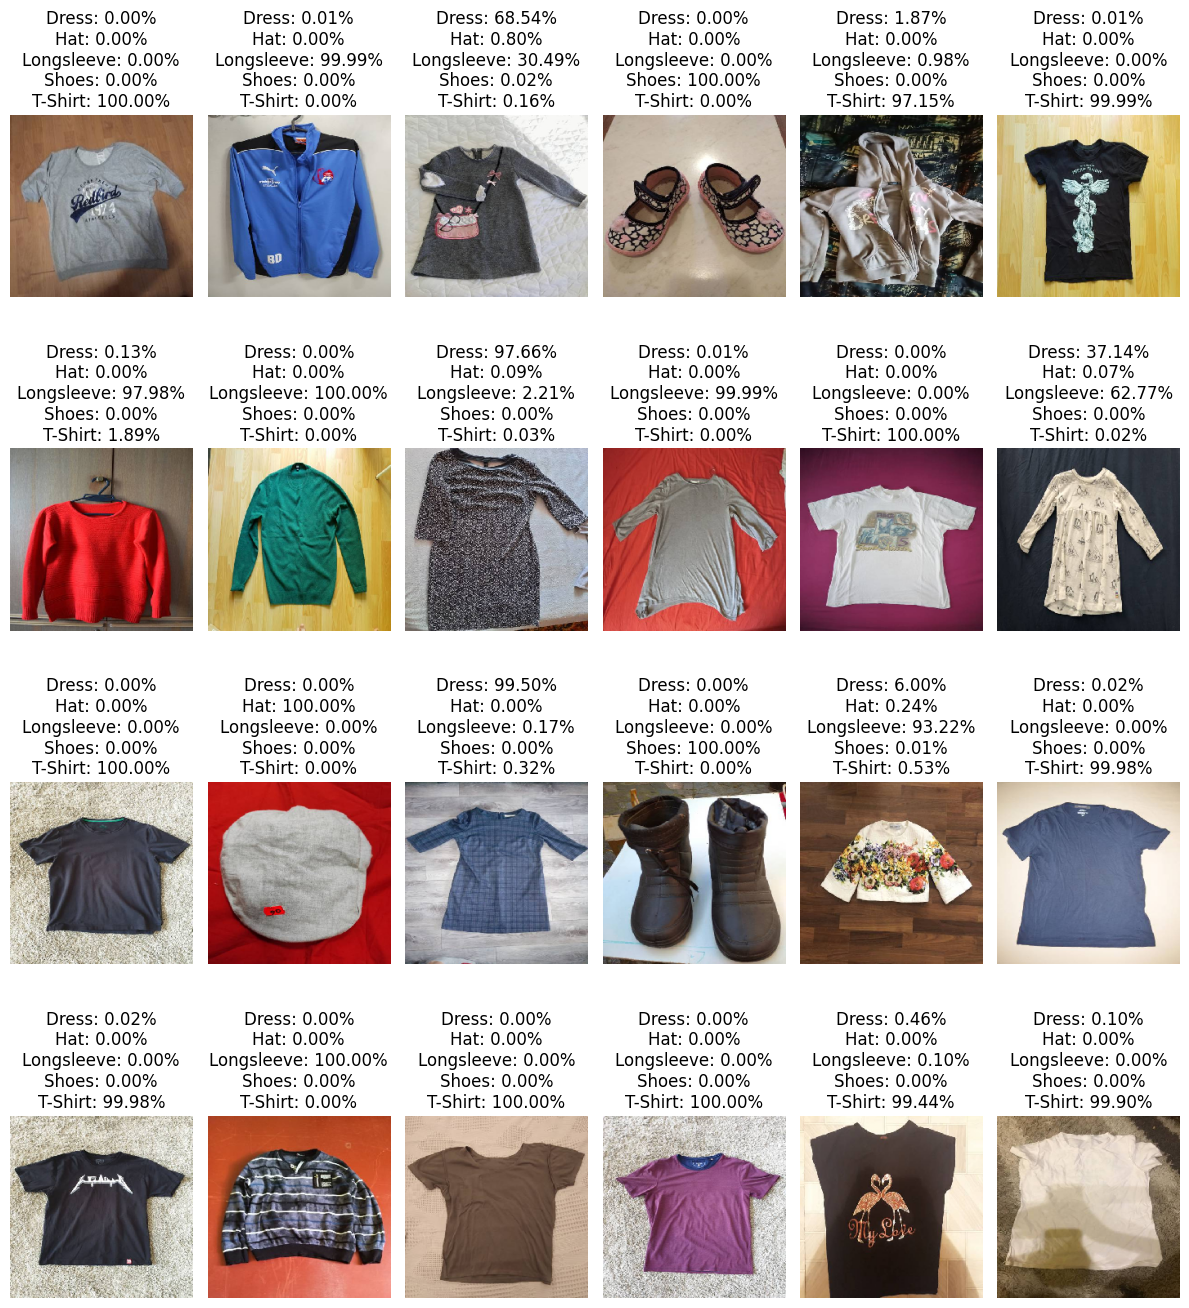

In [6]:
#
# Visualize image class probabilities 
#
def decode_label_prob(y, classes):
    labels = []
    for i ,c in enumerate(classes):
        labels.append(f'{c}: {y[i]:.2%}')
    return labels

n_col, n_row = 6, 4
f, ax = plt.subplots(n_row, n_col, figsize=(12, 14))
for i in range(n_row):
    for j in range(n_col):
        idx = n_col*i + j
        class_probs = transfer_model.predict(x_test[idx:idx+1])[0]
        ax[i, j].imshow(x_test[idx]/255)
        ax[i, j].set_axis_off()
        ax[i, j].set_title('\n'.join(decode_label_prob(class_probs, mlb.classes_)))
        
plt.tight_layout()

# Visualize the Embedding Space
We use the pot layer of the network to produce image embeddings, project them onto a 2D plane using tSNE, and visualize the embedding space.

Visual search can be performed by searching nearest neighbors of a given image (query image) in the embedding space.

In [7]:
#
# Compute the embeddings for visualization
#
n_samples = 1000
embedding_outputs = transfer_model.get_layer('embeddigns').output
embedding_model = Model([transfer_model.input], embedding_outputs)

images = x_test[0:n_samples]
image_embeddings = embedding_model.predict(images)
image_labels = decode_labels(y_test[0:n_samples], mlb)
print(image_embeddings.shape)

21/21 [==============================] - 44s 2s/step
(668, 32)


/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


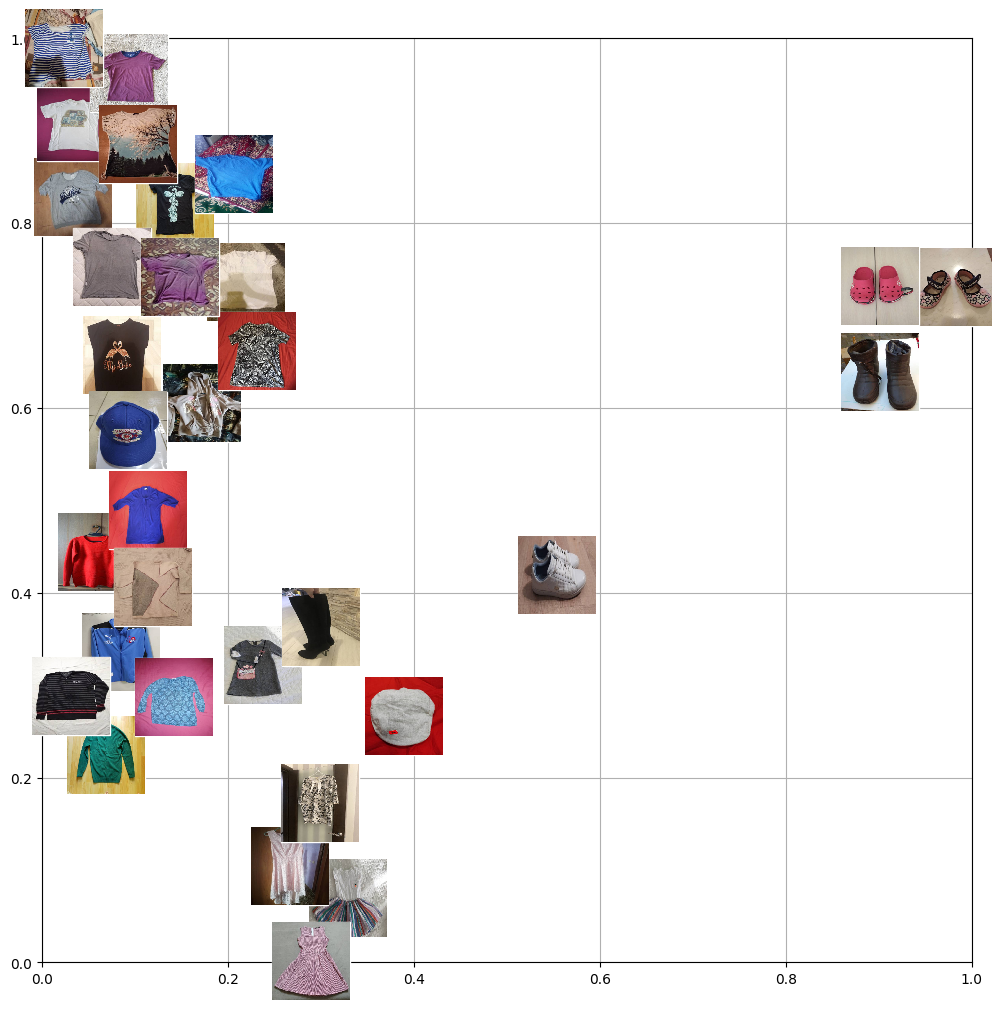

In [8]:
#
# Visualize the 2D-projection of the embedding space with example images (thumbnails)
#
def embedding_plot(X, y_labels, images, mode = 'points', thumbnail_sparsity = 0.005, thumbnail_size = 0.25):
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    X = (X - x_min) / (x_max - x_min)
    fig, ax = plt.subplots(1, figsize=(12, 12))
    
    if mode == 'points':
        uniq = list(set(y_labels))
        z = range(1, len(uniq))
        hot = plt.get_cmap('viridis')
        cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)
    
        for i in range(len(uniq)):
            indx = np.argwhere(y_labels == uniq[i]).T
            ax.scatter(X[indx, 0], X[indx, 1], s=30, marker='o', 
                    color=scalarMap.to_rgba(i), label=uniq[i], alpha=0.5) 
        plt.legend(loc='upper left')

    if mode == 'thumbnails':
        shown_images = np.array([[1., 1.]])
        for i in range(X.shape[0]):
            if np.min(np.sum((X[i] - shown_images) ** 2, axis=1)) < thumbnail_sparsity: continue
            shown_images = np.r_[shown_images, [X[i]]]
            thumbnail = offsetbox.OffsetImage(images[i], cmap=plt.cm.gray_r, zoom=thumbnail_size)
            ax.add_artist(offsetbox.AnnotationBbox(thumbnail, X[i], bboxprops = dict(edgecolor='white'), pad=0.0))

    plt.grid(True)
    
tsne = manifold.TSNE(n_components=2, init='pca', perplexity=20, random_state=0)
X_tsne = tsne.fit_transform(image_embeddings)
embedding_plot(X_tsne, y_labels=image_labels, images=images/255, mode = 'thumbnails')

In [9]:
df.head(5)

image  sender_id    label   kids
1  ea7b6656-3f84-4eb3-9099-23e623fc1018        148  T-Shirt  False
3  ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa         43  T-Shirt  False
4  3b86d877-2b9e-4c8b-a6a2-1d87513309d0        189    Shoes  False
7  4c8f245e-a039-46fd-a6b9-1bb51e83fc05        226  T-Shirt  False
9  bf78527f-0734-44fd-a968-f6c32c12d61e        175    Shoes  False

In [11]:
tmp=df.drop(columns=['sender_id', 'kids'])
tmp.head(5)

image    label
1  ea7b6656-3f84-4eb3-9099-23e623fc1018  T-Shirt
3  ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa  T-Shirt
4  3b86d877-2b9e-4c8b-a6a2-1d87513309d0    Shoes
7  4c8f245e-a039-46fd-a6b9-1bb51e83fc05  T-Shirt
9  bf78527f-0734-44fd-a968-f6c32c12d61e    Shoes

In [57]:
tmp_T=tmp.loc[tmp['label']=='T-Shirt'].reset_index().T.drop(index=['label','index'])
tmp_S=tmp.loc[tmp['label']=='Shoes'].reset_index().T.drop(index=['label','index'])
tmp_D=tmp.loc[tmp['label']=='Dress'].reset_index().T.drop(index=['label','index'])
tmp_H=tmp.loc[tmp['label']=='Hat'].reset_index().T.drop(index=['label','index'])
tmp_L=tmp.loc[tmp['label']=='Longsleeve'].reset_index().T.drop(index=['label','index'])

tmp_T

0     \
image  ea7b6656-3f84-4eb3-9099-23e623fc1018   

                                       1     \
image  ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa   

                                       2     \
image  4c8f245e-a039-46fd-a6b9-1bb51e83fc05   

                                       3     \
image  95609fcf-b2c2-4f35-8454-a308262e30ea   

                                       4     \
image  534cb9e4-658e-48a9-a9d9-365149ee52e8   

                                       5     \
image  be698ba0-7a2c-4f38-84ea-6223dc15854d   

                                       6     \
image  f968404d-6c3a-465e-9edd-347784880455   

                                       7     \
image  c395de85-824c-4cbe-ad6b-ed80f5c15fb7   

                                       8     \
image  4acdd295-b0b4-4991-a6cd-c9d2c322c347   

                                       9     ...  \
image  330f1f98-0d3d-4c64-bd82-518e6e157d08  ...   

                                       1001  \
image  4f242ce1-8493-408d-ae63-2422a7cdc21e   

                                       1002  \
image  4a59229a-9898-40e6-9914-a13d9a9cf661   

                                       1003  \
image  9db6122f-e222-48f3-8147-fd1e56e92a6a   

                                       1004  \
image  d9876909-14f3-4b0a-8523-226e0c7e14db   

                                       1005  \
image  e13f0056-a908-4593-aa86-de593774c049   

                                       1006  \
image  3e88a1d2-832b-49bd-b471-53f03b1b66ff   

                                       1007  \
image  c77e1d3d-5aad-4df9-8bb6-2359bd1c7714   

                                       1008  \
image  ab7a19b9-5387-417f-8294-8d976dfa948a   

                                       1009  \
image  0d1df3d4-ad7f-43f8-9673-90d368f6c853   

                                       1010  
image  29cffc8e-5e72-4b73-bbc0-20b9f1251bc2  

[1 rows x 1011 columns]

In [64]:
df_concat=pd.concat([tmp_T,tmp_S,tmp_D,tmp_H,tmp_L])
df_concat.index=['T-shirt','Shoes','Dress','Hat','Longsleeve']
df_concat

0     \
T-shirt     ea7b6656-3f84-4eb3-9099-23e623fc1018   
Shoes       3b86d877-2b9e-4c8b-a6a2-1d87513309d0   
Dress       e3c8e575-c5b8-4c4c-9f49-62b37b611b6b   
Hat         a283e901-d8da-4be1-91ae-2a3c94de48a2   
Longsleeve  5805e9ba-176c-461b-87f7-ff400291d0fc   

                                            1     \
T-shirt     ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa   
Shoes       bf78527f-0734-44fd-a968-f6c32c12d61e   
Dress       e6a8b33f-279c-4072-8dba-229d94205e55   
Hat         54e4e91f-b255-4e2d-906f-c482432a7048   
Longsleeve  8f6822c3-862b-4126-9a35-585569aec240   

                                            2     \
T-shirt     4c8f245e-a039-46fd-a6b9-1bb51e83fc05   
Shoes       61bbb3a2-2ee0-47bd-b3f9-2675b3076302   
Dress       4b8e5d41-3e12-4d2b-8634-e62e71d613ff   
Hat         b6899eaa-fe32-4547-9217-05bbcb09c217   
Longsleeve  e85b5945-e8d0-4049-84b4-22ff5907ec8e   

                                            3     \
T-shirt     95609fcf-b2c2-4f35-8454-a308262e30ea   
Shoes       08215318-faff-4037-bee9-5bceb0af7747   
Dress       cb61ac26-e7a5-42a6-8471-66f69a9ccd4d   
Hat         08b939da-2a7f-46a3-8126-194e09432c3f   
Longsleeve  21183cf1-c20b-4a86-8e86-ab5ca9b26c06   

                                            4     \
T-shirt     534cb9e4-658e-48a9-a9d9-365149ee52e8   
Shoes       a3e5af58-cc70-48b8-85f7-cd160ba95968   
Dress       21059bce-cf86-4064-b9af-5dbbbc6e7593   
Hat         2d6afa47-fd6f-4b2b-9e51-010280547753   
Longsleeve  4eec8a60-15db-46d0-86b4-04e3cd8e75f8   

                                            5     \
T-shirt     be698ba0-7a2c-4f38-84ea-6223dc15854d   
Shoes       30feae84-c7b1-4e72-8b42-0f7736d42cd5   
Dress       334bc6ef-fc89-4226-90f3-dd63645ec845   
Hat         708af227-43ba-4e2b-b35b-652a13cd1c77   
Longsleeve  d9e84490-185d-48f9-ac16-4ef3360616d5   

                                            6     \
T-shirt     f968404d-6c3a-465e-9edd-347784880455   
Shoes       30b6fd9b-d172-4d5d-a1c1-c36d23f769dd   
Dress       1c4c974b-47b3-40bb-a3e2-913e4874dd75   
Hat         a9db59ad-5a9c-4c5d-9a5a-a8aed629cc23   
Longsleeve  bfb072bd-4378-47d5-ad94-e11e367fbdd0   

                                            7     \
T-shirt     c395de85-824c-4cbe-ad6b-ed80f5c15fb7   
Shoes       49d3b29c-54b9-4cae-b918-504cf24ce128   
Dress       f28fb711-b7bf-4d6e-9935-6970a311a14e   
Hat         66807c84-da44-4af2-b9be-3848a52a7073   
Longsleeve  7e3b8120-6f91-4ddc-aa6f-cf49a5dc62aa   

                                            8     \
T-shirt     4acdd295-b0b4-4991-a6cd-c9d2c322c347   
Shoes       d748ed88-9bf7-402e-98a9-7a4c65582e48   
Dress       f1c78283-2da0-45fc-8f20-4f874519d415   
Hat         26fca408-4412-466b-972a-3a160051534a   
Longsleeve  349cf35c-eaad-49af-b0c9-3c88b8d0afc1   

                                            9     ...  \
T-shirt     330f1f98-0d3d-4c64-bd82-518e6e157d08  ...   
Shoes       b7935371-743f-4ad4-9a48-fdb9d0bca9e4  ...   
Dress       744c6ec1-4bdd-4836-8cec-833449eb2f00  ...   
Hat         70731fd8-417c-4d20-94c5-56cf17a7178e  ...   
Longsleeve  9e61d8c2-aaf7-4d5e-b07e-804b082bcf88  ...   

                                            1001  \
T-shirt     4f242ce1-8493-408d-ae63-2422a7cdc21e   
Shoes                                        NaN   
Dress                                        NaN   
Hat                                          NaN   
Longsleeve                                   NaN   

                                            1002  \
T-shirt     4a59229a-9898-40e6-9914-a13d9a9cf661   
Shoes                                        NaN   
Dress                                        NaN   
Hat                                          NaN   
Longsleeve                                   NaN   

                                            1003  \
T-shirt     9db6122f-e222-48f3-8147-fd1e56e92a6a   
Shoes                                        NaN   
Dress                                        NaN   
Hat                                          NaN  

In [66]:
import json
result = df_concat.to_json(orient="split")
parsed = json.loads(result)
json.dumps(parsed, indent=4)  

'{\n    "columns": [\n        0,\n        1,\n        2,\n        3,\n        4,\n        5,\n        6,\n        7,\n        8,\n        9,\n        10,\n        11,\n        12,\n        13,\n        14,\n        15,\n        16,\n        17,\n        18,\n        19,\n        20,\n        21,\n        22,\n        23,\n        24,\n        25,\n        26,\n        27,\n        28,\n        29,\n        30,\n        31,\n        32,\n        33,\n        34,\n        35,\n        36,\n        37,\n        38,\n        39,\n        40,\n        41,\n        42,\n        43,\n        44,\n        45,\n        46,\n        47,\n        48,\n        49,\n        50,\n        51,\n        52,\n        53,\n        54,\n        55,\n        56,\n        57,\n        58,\n        59,\n        60,\n        61,\n        62,\n        63,\n        64,\n        65,\n        66,\n        67,\n        68,\n        69,\n        70,\n        71,\n        72,\n        73,\n        74,\n        75,\n